In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
from torchtext import datasets

import random
import numpy as np

import time

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
TEXT = data.Field(tokenize = 'spacy', lower = True)
LABEL = data.LabelField()

In [0]:
train_data, valid_data, test_data = datasets.SNLI.splits(TEXT, LABEL)

In [5]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 549367
Number of validation examples: 9842
Number of testing examples: 9824


In [6]:
print(vars(train_data.examples[0]))


{'premise': ['a', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.'], 'hypothesis': ['a', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.'], 'label': 'neutral'}


In [0]:
MIN_FREQ = 2

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")


Unique tokens in TEXT vocabulary: 23566


In [9]:
print(TEXT.vocab.freqs.most_common(20))


[('a', 1438991), ('.', 962558), ('the', 534692), ('in', 407296), ('is', 373543), ('man', 266236), ('on', 235904), ('and', 206363), ('are', 199114), ('of', 192428), ('with', 169236), ('woman', 137630), ('two', 122259), ('people', 121154), (',', 114331), ('to', 113972), ('at', 98656), ('wearing', 81024), ('an', 80212), ('his', 72467)]


In [10]:
print(TEXT.vocab.itos[:10])


['<unk>', '<pad>', 'a', '.', 'the', 'in', 'is', 'man', 'on', 'and']


In [11]:
print(LABEL.vocab.itos)


['entailment', 'contradiction', 'neutral']


In [12]:
print(LABEL.vocab.freqs.most_common())


[('entailment', 183416), ('contradiction', 183187), ('neutral', 182764)]


In [0]:

BATCH_SIZE = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=1)
        self.translation = nn.Linear(emb_dim, enc_hid_dim)
        self.rnn = nn.GRU(enc_hid_dim,
                          enc_hid_dim, 
                          num_layers=n_layers, 
                          bidirectional=True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.fc = nn.Linear(enc_hid_dim * 2, enc_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]

        lengths = (src!=1).sum(axis=0)
        
        embedded = self.embedding(src)
        
        #embedded = [src len, batch size, emb dim]

        translated = F.relu(self.translation(embedded))

        #translated = [src len, batch size, hid dim]

        packed_embedded = nn.utils.rnn.pack_padded_sequence(translated, lengths, enforce_sorted=False)
        
        packed_output, hidden = self.rnn(packed_embedded)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_output)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #outputs over padding tokens are zero tensors
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, enc hid dim]
        
        return outputs, hidden
    
    
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, att_size):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + enc_hid_dim, att_size)
        self.v = nn.Linear(att_size, 1, bias = False)
        
    def forward(self, encoder_outputs, hidden):
        
        #hidden = [batch size, enc hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, enc hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, att_size]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)
    
    
class Attention_encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, n_layers, dropout, att_size):
        super(Attention_encoder, self).__init__()
        
        self.enc = Encoder(input_dim, emb_dim, enc_hid_dim, n_layers, dropout)
        self.att =  Attention(enc_hid_dim , att_size)
        
    def forward(self, text):
        
        #text = [src len, batch size]
        
        out, hid = self.enc(text)
        
        #out = [src len, batch size, enc hid dim * 2]
        #hid = [batch size, enc hid dim]

        a = self.att(out, hid)
        
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        out = out.permute(1,0,2)
        
        #out = [batch size, src len, enc hid dim * 2]
        
        weighted_out = torch.bmm(a,out)
        
        #weighted_out = [batch size, 1, enc hid dim *2]
        
        weighted_out = weighted_out.permute(1, 0, 2)
        
        #weighted_out = [1, batch size, enc hid dim *2]
        
        weighted_out = weighted_out.squeeze()
        
        #weighted_out = [batch size, enc hid dim *2]

        return weighted_out


class NLI_Bahdanau(nn.Module):
    
    def __init__(self, input_dim, emb_dim, enc_hid_dim, n_layers, dropout, att_size, n_fc_layers, output_dim):
        super(NLI_Bahdanau, self).__init__()

        self.attention_layer = Attention_encoder(input_dim, emb_dim, enc_hid_dim, n_layers, dropout, att_size)

        fc_dim = enc_hid_dim * 2
        fcs = [nn.Linear(fc_dim * 2, fc_dim * 2) for _ in range(n_fc_layers)]
        self.fcs = nn.ModuleList(fcs)
        self.fc_out = nn.Linear(fc_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, prem, hypo):
        #prem, hypo = [sent len, batch size]

        hidden_prem = self.attention_layer(prem)
        hidden_hypo = self.attention_layer(hypo)
        #sentences = [batch size, hid dim * num directions]

        hidden = torch.cat((hidden_prem, hidden_hypo), dim=1)
        #hidden = [batch size, hid dim * num directions * 2]

        for fc in self.fcs:
                hidden = fc(hidden)
                hidden = F.relu(hidden)
                hidden = self.dropout(hidden)

        prediction = self.fc_out(hidden)
        #prediction = [batch size, output dim]

        return prediction

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 300
N_LSTM_LAYERS = 2
N_FC_LAYERS = 3
ATT_SIZE = 300
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = NLI_Bahdanau(INPUT_DIM,
                  EMBEDDING_DIM,
                  HIDDEN_DIM,
                  N_LSTM_LAYERS,
                  DROPOUT,
                  ATT_SIZE,
                  N_FC_LAYERS,
                  OUTPUT_DIM).to(device)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,645,403 trainable parameters


In [17]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

model.attention_layer.enc.embedding.weight.data.copy_(pretrained_embeddings)
model.attention_layer.enc.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.attention_layer.enc.embedding.weight.requires_grad = False

torch.Size([23566, 300])


In [18]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,575,603 trainable parameters


In [0]:
optimizer = optim.Adam(model.parameters())


In [0]:
criterion = nn.CrossEntropyLoss().to(device)


In [0]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        prem = batch.premise
        hypo = batch.hypothesis
        labels = batch.label

        #prem = [prem sent len, batch size]
        #hypo = [hypo sent len, batch size]

        optimizer.zero_grad()
        
        predictions = model(prem, hypo)
        
        #predictions = [batch size, output dim]
        #labels = [batch size]
        
        loss = criterion(predictions, labels)
                
        acc = categorical_accuracy(predictions, labels)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            prem = batch.premise
            hypo = batch.hypothesis
            labels = batch.label
                        
            predictions = model(prem, hypo)
            
            loss = criterion(predictions, labels)
                
            acc = categorical_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
N_EPOCHS = 100

best_valid_loss = float('inf')
counter = 0
patience = 2


acc=[]
val_acc=[]

loss=[]
val_loss=[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    acc.append(train_acc)
    loss.append(train_loss)
    
    val_acc.append(valid_acc)
    val_loss.append(valid_loss)

    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      #torch.save(model.state_dict(), 'tut2-model.pt')
      counter = 0 
    else:
      counter += 1
      if counter >= patience:
          break


Epoch: 01 | Epoch Time: 4m 36s
	Train Loss: 0.758 | Train Acc: 66.48%
	 Val. Loss: 0.625 |  Val. Acc: 73.87%
Epoch: 02 | Epoch Time: 4m 36s
	Train Loss: 0.609 | Train Acc: 75.12%
	 Val. Loss: 0.561 |  Val. Acc: 77.10%
Epoch: 03 | Epoch Time: 4m 37s
	Train Loss: 0.551 | Train Acc: 77.92%
	 Val. Loss: 0.517 |  Val. Acc: 79.17%
Epoch: 04 | Epoch Time: 4m 36s
	Train Loss: 0.510 | Train Acc: 79.86%
	 Val. Loss: 0.486 |  Val. Acc: 80.69%
Epoch: 05 | Epoch Time: 4m 36s
	Train Loss: 0.478 | Train Acc: 81.27%
	 Val. Loss: 0.487 |  Val. Acc: 80.44%
Epoch: 06 | Epoch Time: 4m 36s
	Train Loss: 0.446 | Train Acc: 82.69%
	 Val. Loss: 0.469 |  Val. Acc: 81.52%
Epoch: 07 | Epoch Time: 4m 37s
	Train Loss: 0.416 | Train Acc: 83.98%
	 Val. Loss: 0.470 |  Val. Acc: 81.65%
Epoch: 08 | Epoch Time: 4m 36s
	Train Loss: 0.387 | Train Acc: 85.18%
	 Val. Loss: 0.468 |  Val. Acc: 82.29%
Epoch: 09 | Epoch Time: 4m 35s
	Train Loss: 0.359 | Train Acc: 86.31%
	 Val. Loss: 0.495 |  Val. Acc: 81.92%
Epoch: 10 | Epoch T

In [26]:
# model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.499 |  Test Acc: 81.75%


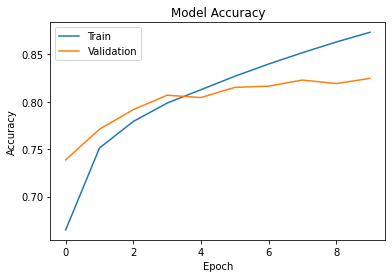

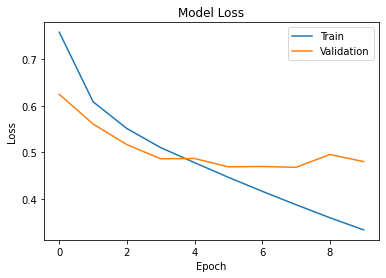

In [27]:
import matplotlib.pyplot as plt

plt.plot(acc)
plt.plot(val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [0]:
def predict_inference(premise, hypothesis, text_field, label_field, model, device):
    
    model.eval()
    
    if isinstance(premise, str):
        premise = text_field.tokenize(premise)
    
    if isinstance(hypothesis, str):
        hypothesis = text_field.tokenize(hypothesis)
    
    if text_field.lower:
        premise = [t.lower() for t in premise]
        hypothesis = [t.lower() for t in hypothesis]
        
    premise = [text_field.vocab.stoi[t] for t in premise]
    hypothesis = [text_field.vocab.stoi[t] for t in hypothesis]
    
    premise = torch.LongTensor(premise).unsqueeze(1).to(device)
    hypothesis = torch.LongTensor(hypothesis).unsqueeze(1).to(device)

    return premise, hypothesis
    # premise = premise.transpose(1,0)
    # hypothesis = hypothesis.transpose(1,0)
    
    # prediction = model(premise, hypothesis)
    # return prediction
    # prediction = prediction.argmax(dim=-1).item()
    
    # return label_field.vocab.itos[prediction]

In [0]:

premise = 'a man sitting on a green bench.'
hypothesis = 'a woman sitting on a green bench.'

p, h = predict_inference(premise, hypothesis, TEXT, LABEL, model, device)


In [55]:
p

tensor([[  2],
        [  7],
        [ 32],
        [  8],
        [  2],
        [ 60],
        [150],
        [  3]], device='cuda:0')

In [56]:
h

tensor([[  2],
        [ 13],
        [ 32],
        [  8],
        [  2],
        [ 60],
        [150],
        [  3]], device='cuda:0')

In [0]:
batch= next(iter(valid_iterator))

In [0]:
pb=batch.premise[:,0]
# pb=pb.transpose(1,0)

In [0]:
hb=batch.hypothesis[:,0]
# hb=hb.transpose(1,0)

In [78]:
model(pb.to(device),hb.to(device))

RuntimeError: ignored